# **Document Clustering and Topic Modeling**

In this project, I analyzed a group of e-commercial product reviews and use unsupervised learning models to partition unlabeled reviews into different clusters, visualize the results and identify their latent topics/structures.

## Contents

* [Part 1: Load Data and Exploratory Data Analysis](#Part1-Load-Data)
* [Part 2: Feature Extraction](#Part2-Feature-Extraction)
* [Part 3: K-means clustering](#Part3-KMeans)
* [Part 4: Latent Dirichlet Allocation Topic Modeling](#Part4-LDA-Topic-Modeling)


<a name = 'Part1-Load-Data'></a>
## **Part 1: Load Data and Exploratory Data Analysis**

### 1.0 Setup Google Drive Environment

In [ ]:
!pip install -U -q PyDrive

from google.colab import auth
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# https://drive.google.com/open?id=192JMR7SIqoa14vrs7Z9BXO3iK89pimJL
file = drive.CreateFile({'id':'134g3qCihn6QFOOZJyn0VAYp6bdNBk-B0'}) # replace the id with id of file you want to access
file.GetContentFile('data.tsv')

### 1.1 Load Data

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('data.tsv', sep='\t', header=0, on_bad_lines='skip')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


### 1.2 Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960197 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [ ]:
df.nunique()

marketplace               1
customer_id          719522
review_id            960204
product_id           149658
product_parent       141818
product_title        143436
product_category          1
star_rating               5
helpful_votes           284
total_votes             309
vine                      2
verified_purchase         2
review_headline      456703
review_body          873427
review_date            4173
dtype: int64

In [ ]:
df.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          2
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline        7
review_body          148
review_date            4
dtype: int64

In [ ]:
# Remove missing value
df.dropna(subset='review_body', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960056 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 117.2+ MB


In [ ]:
# use the first N-rows data as our training data
N = 1000
reviews = df.loc[:N, 'review_body'].tolist()

<a name = 'Part2-Feature-Extraction'></a>
## **Part 2: Feature Extraction**

### 2.0 nltk tool

In [ ]:
import nltk
import re # REGULAR EXPRESSION
#import gensim

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 2.1 Tokenizing and Stemming

In [ ]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print (f"We use {len(stopwords)} stop-words from nltk library.")
#print (stopwords)

We use 179 stop-words from nltk library.


In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text, stem=True):
    # exclude stop words and tokenize the document, generate a list of string
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word not in stopwords]

    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    # stemming
    if stem:
        filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]

    return filtered_tokens

In [ ]:
# tokenization and stemming
tokenization_and_stemming(reviews[0])

['absolut',
 'love',
 'watch',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'i',
 'wear',
 'dainti']

### 2.2 Build a **wordcloud** to show relative importance of words

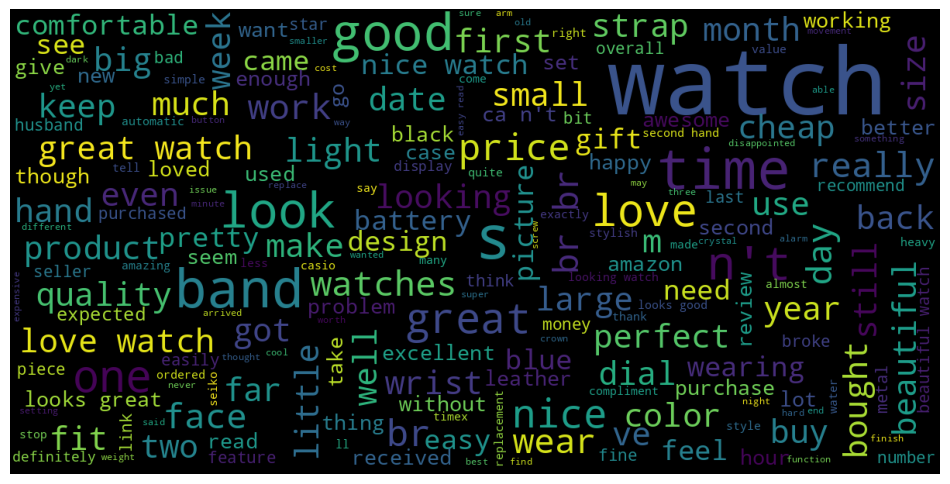

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloudShow(text):
    wordcloud = WordCloud(
        background_color='black',
        max_words=300,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(text)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

def tokenizedWords(reviews):
    tokenized_words = []
    stemmed_words = []
    for review in reviews:
        tokenized_words += tokenization_and_stemming(review, stem=False)
        stemmed_words += tokenization_and_stemming(review)
    return tokenized_words, stemmed_words

tokenized_words, stemmed_words = tokenizedWords(reviews)
# create a mapping from stemmed words to original words
stemmed_to_tokenized = {stemmed_words[i]: tokenized_words[i] for i in range(len(stemmed_words))}

wordcloudShow(' '.join(tokenized_words))
#wordcloudShow(' '.join(stemmed_words))

<a name = 'Part3-KMeans'></a>
## **Part 3: K-means clustering**

### 3.1 TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(
    max_df=0.99, max_features=1000,
    min_df=0.01, token_pattern = None, # stop_words='english',
    use_idf=True, tokenizer=tokenization_and_stemming,
    ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(reviews)

print(f'tfidf_matrix shape: {tfidf_matrix.shape}')
def get_sparsity(csr_m):
  shape = csr_m.get_shape()
  print(f'tfidf_matrix Sparsity: {(csr_m.size * 1.0 / shape[0] / shape[1] * 100):,.3f}%')
get_sparsity(tfidf_matrix)

tfidf_matrix shape: (1000, 282)
tfidf_matrix Sparsity: 3.173%


In [ ]:
# check the parameters
# tfidf_model.get_params()

# tf-idf valid words
tfidf_words = tfidf_model.get_feature_names_out()

#### 3.1.1 Visualize the review data along 2-principal PCA axises

Sparsicity: 3.17%


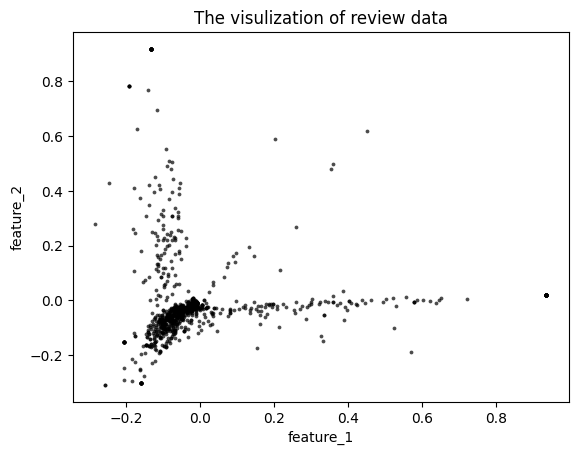

In [ ]:
from sklearn.decomposition import PCA

def pcaFeature(csr_matrix):
    X = csr_matrix.toarray(order='C')
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    X = pd.DataFrame(
        {
            'feature1': X[:, 0],
            'feature2': X[:, 1]
        }
    )
    return X, pca

X_2dim, pca = pcaFeature(tfidf_matrix)

fig, ax = plt.subplots()
ax.scatter(X_2dim.feature1, X_2dim.feature2, marker='.', c='k', s=30, lw=0, alpha=0.7, edgecolor='k')
ax.set_title('The visulization of review data')
ax.set_xlabel("feature_1")
_ = ax.set_ylabel("feature_2")

### 3.2 K-means clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

def silhouette_eval(tfidf_matrix, labels, n_cluster, ax, fig_space=10):
  silhouette_avg = silhouette_score(tfidf_matrix, labels)
  silhouette_vals = silhouette_samples(tfidf_matrix, labels)
  ax.set_ylim([0, tfidf_matrix.shape[0] + (n_cluster + 1) * fig_space])
  y_lower = fig_space
  for i in range(n_cluster):
    ith_silhouette_vals = silhouette_vals[labels == i]
    ith_silhouette_vals.sort()
    y_upper = y_lower + ith_silhouette_vals.shape[0]
    color = cm.nipy_spectral(float(i) / n_cluster)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_silhouette_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper + fig_space
  ax.axvline(x = silhouette_avg, color='red', linestyle='--')
  ax.set_title("The silhouette evaluation of clusters")
  ax.set_xlabel("The silhouette value")
  ax.set_ylabel("Cluster label")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  return silhouette_avg

def visualize_datas(X_2dim, labels, n_cluster, centers, ax):
  colors = cm.nipy_spectral(labels.astype(float) / n_cluster)
  ax.scatter(X_2dim.feature1, X_2dim.feature2,
             marker=".", s=30, lw=0, alpha=0.7,
             c=colors, edgecolor="k")
  ax.scatter(centers[:, 0], centers[:, 1],
             marker='o', s=200, alpha=1,
             c="white", edgecolor="k")
  for i, c in enumerate(centers):
    ax.scatter(c[0], c[1],
               marker="$%d$" % i, alpha=1,
               s=50, edgecolor='k')
  ax.set_title("The visualization of the clustering")
  ax.set_xlabel("feature_1")
  ax.set_ylabel("feature_2")


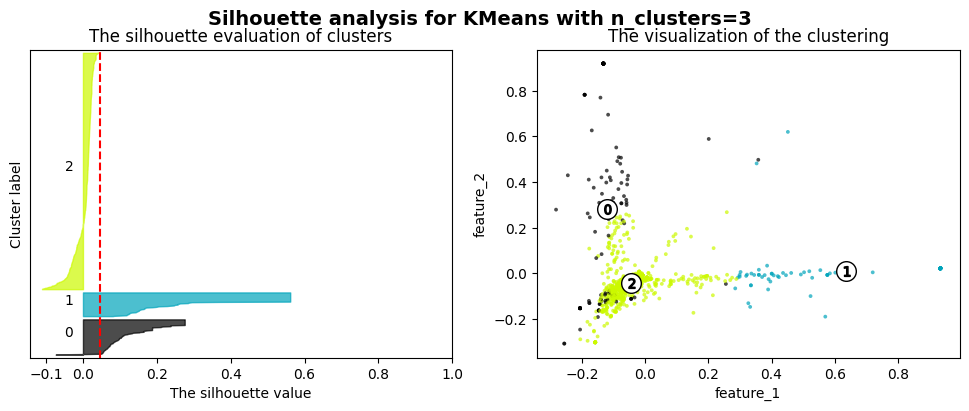

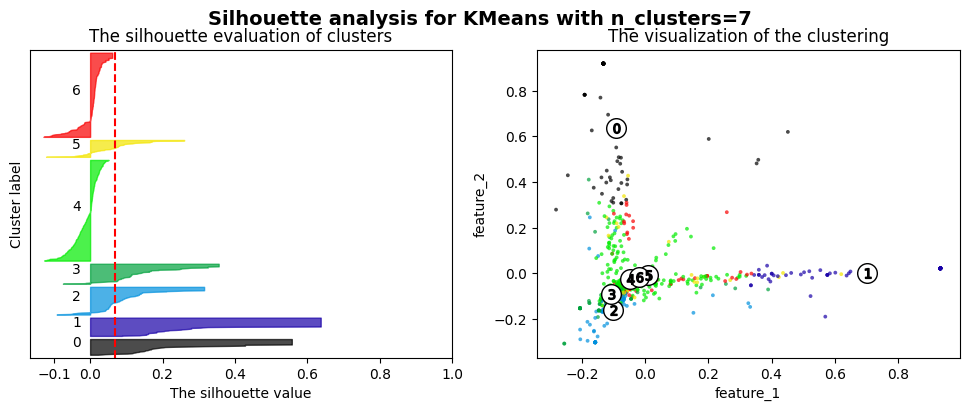

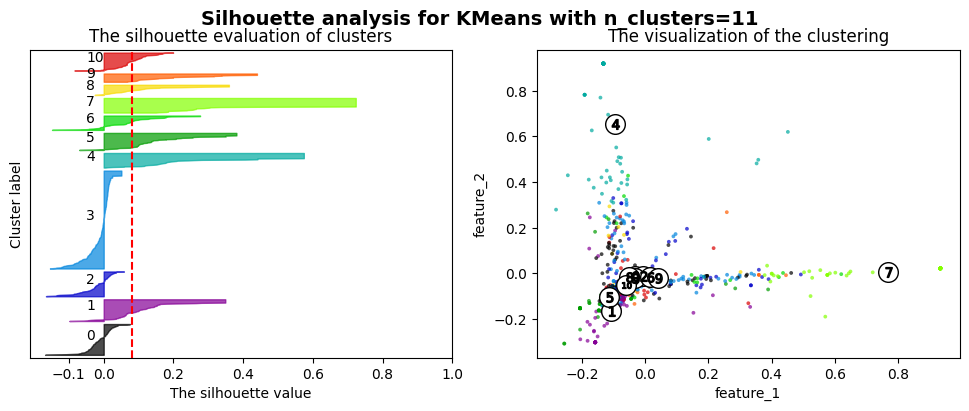

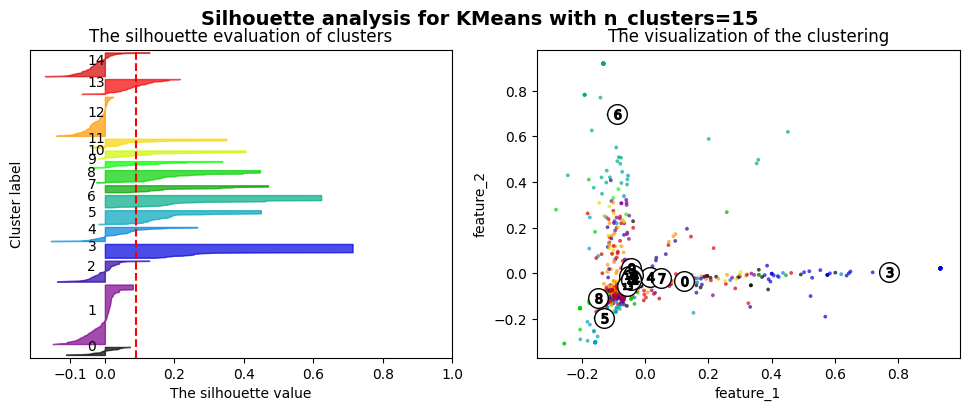

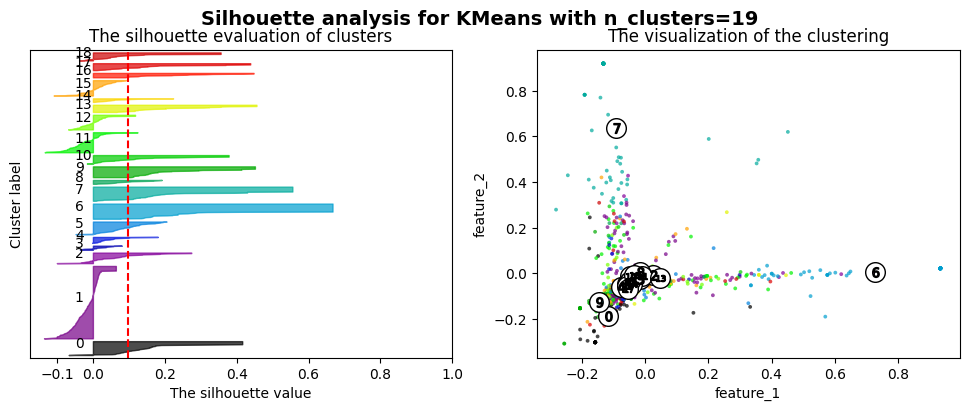

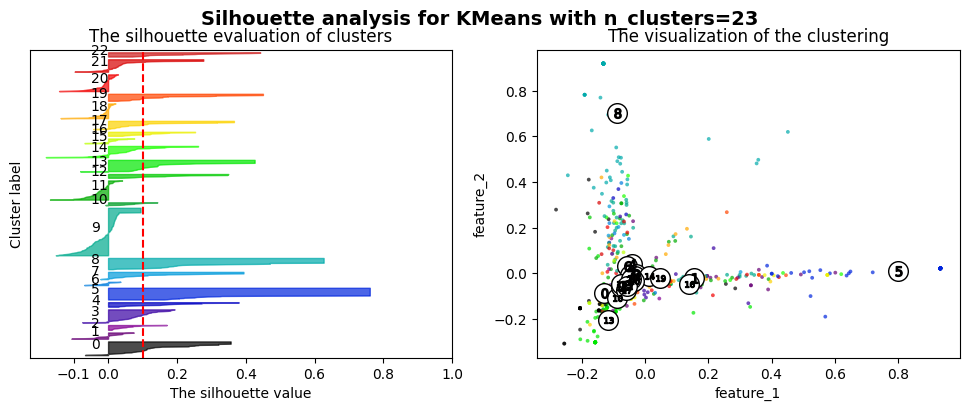

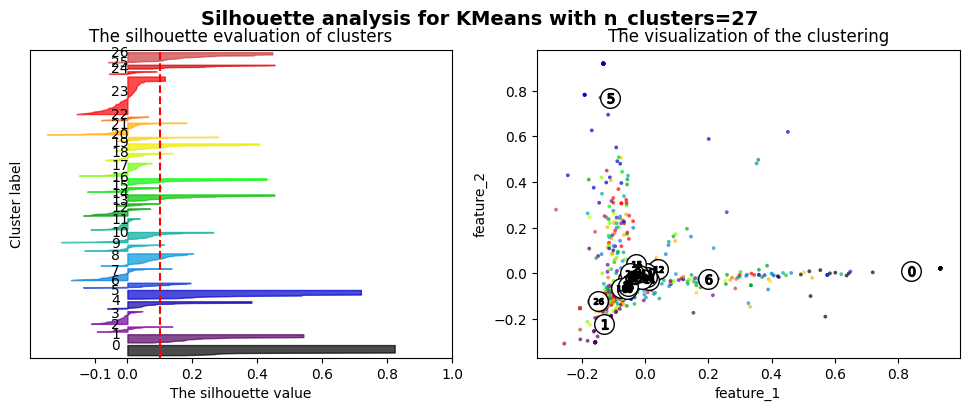

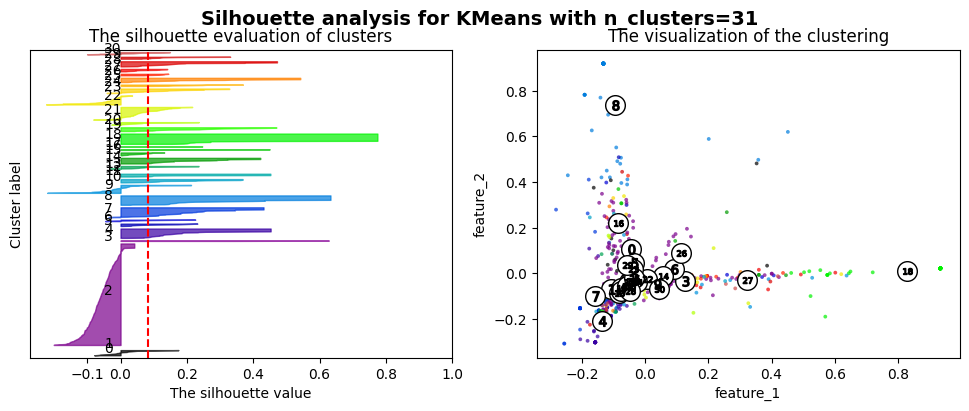

In [ ]:
n_clusters = range(3, 32, 4)
inertias = []
silhouettes = []

for n_cluster in n_clusters:
    KMeans_m = KMeans(n_clusters=n_cluster, n_init=10, random_state=10)
    labels = KMeans_m.fit_predict(tfidf_matrix)
    centers = pca.transform(KMeans_m.cluster_centers_)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    silhouette_avg = silhouette_eval(tfidf_matrix, labels, n_cluster, ax1)
    inertia = KMeans_m.inertia_
    visualize_datas(X_2dim, labels, n_cluster, centers, ax2)
    plt.suptitle(f"Silhouette analysis for KMeans with n_clusters={n_cluster}",
                 fontsize=14, fontweight="bold")
    # choose the best super param
    if not inertias or inertia < inertias[-1] or (inertia - inertias[-1]) / inertia < 0.03:
        if not silhouettes or silhouette_avg > silhouettes[-1] or \
                (silhouettes[-1] - silhouette_avg) / silhouette_avg < 0.03:
            best_model = [n_cluster, labels, KMeans_m.cluster_centers_]
    # training history
    silhouettes.append(silhouette_avg)
    inertias.append(inertia)


#### 3.2.1 K-means clustering trining history

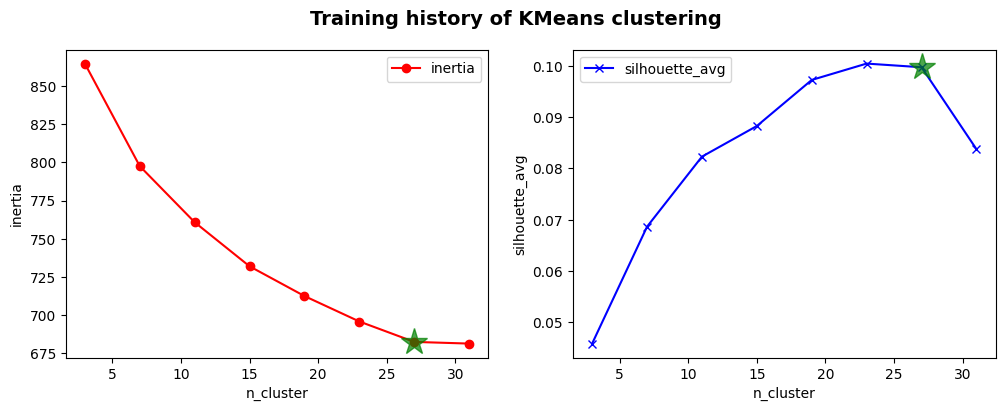

In [ ]:
idx = n_clusters.index(best_model[0])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(n_clusters, inertias, 'ro-', label='inertia')
axs[0].plot(n_clusters[idx], inertias[idx], c='g', marker='*', markersize=20, alpha=0.7)
axs[1].plot(n_clusters, silhouettes, 'bx-', label='silhouette_avg')
axs[1].plot(n_clusters[idx], silhouettes[idx], c='g', marker='*', markersize=20, alpha=0.7)
axs[0].set_xlabel('n_cluster')
axs[0].set_ylabel('inertia')
axs[0].legend()
axs[1].set_xlabel('n_cluster')
axs[1].set_ylabel('silhouette_avg')
axs[1].legend()
_ = plt.suptitle(f"Training history of KMeans clustering", fontsize=14, fontweight="bold")

### 3.3 Analyze K-means Clustring Result

In [ ]:
KMeans_clustering = pd.DataFrame(
    {'product_title': df[:N].product_title,
     'reviews': reviews,
     'cluster': best_model[1]
     }
)
KMeans_clustering.head()

,product_title,reviews,cluster
0,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Absolutely love this watch! Get compliments al...,23
1,Kenneth Cole New York Women's KC4944 Automatic...,I love this watch it keeps time wonderfully.,1
2,Ritche 22mm Black Stainless Steel Bracelet Wat...,Scratches,23
3,Citizen Men's BM8180-03E Eco-Drive Stainless S...,"It works well on me. However, I found cheaper ...",10
4,Orient ER27009B Men's Symphony Automatic Stain...,Beautiful watch face. The band looks nice all...,8


#### 3.3.1 Clusters size distribution

In [ ]:
KMeans_clustering_stat = pd.concat(
    [KMeans_clustering['cluster'].value_counts(),
     KMeans_clustering['cluster'].value_counts(normalize=True).mul(100)],
    axis=1,keys=('counts','percentage')
)
KMeans_clustering_stat['cluster'] = [f'cluster-{i}' for i in KMeans_clustering_stat.index]
KMeans_clustering_stat.sort_values(by='percentage', ascending=False).head()

,counts,percentage,cluster
23,157,15.7,cluster-23
3,54,5.4,cluster-3
17,54,5.4,cluster-17
8,52,5.2,cluster-8
7,50,5.0,cluster-7


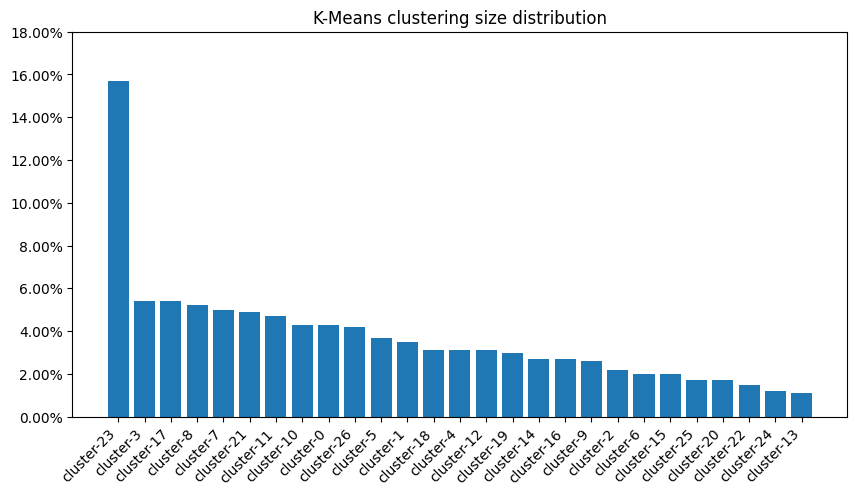

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(KMeans_clustering_stat.cluster, KMeans_clustering_stat.percentage)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{y:.2f}%' for y in ax.get_yticks()])
_ = ax.set_title('K-Means clustering size distribution')

#### 3.3.2 Keywords for each cluster

In [ ]:
order_centroids = best_model[2].argsort()[:, ::-1]
cluster_keywords = pd.DataFrame()
n_keywds = 10
for i in KMeans_clustering_stat.index:
  cluster_keywords[f'cluster-{i}'] = [stemmed_to_tokenized[tfidf_words[order_centroids[i][j]]] for j in range(n_keywds)]
cluster_keywords.head(n_keywds)

,cluster-23,cluster-3,cluster-17,cluster-8,cluster-7,cluster-21,cluster-11,cluster-10,cluster-0,cluster-26,...,cluster-16,cluster-9,cluster-2,cluster-6,cluster-15,cluster-25,cluster-20,cluster-22,cluster-24,cluster-13
0,watch,watch,band,br,looks,'s,watch,work,good,great,...,perfect,little,picture,product,strap,awesome,pretty,months,money,leather
1,expected,days,watch,watch,watch,watch,battery,well,quality,watch,...,fits,watch,better,good,super,watch,loved,'ve,watch,band
2,time,one,n't,'s,good,really,hand,stop,fast,looks,...,watch,big,watch,great,nice,quickly,much,watch,less,watch
3,n't,broke,looks,band,big,nice,replaced,n't,shipped,loved,...,expected,time,loved,seller,great,loved,watch,loved,back,looks
4,light,got,well,looks,cheap,loved,used,great,loved,comfortable,...,sized,face,looks,excellent,watch,price,big,like,worth,thickness
5,nice,buy,wrist,n't,loved,good,easy,watch,time,wear,...,'s,tiny,way,battery,fast,arriving,good,starting,beautiful,well
6,wear,compliments,small,time,great,keep,time,good,watch,band,...,wear,great,real,work,'m,design,large,one,great,made
7,get,two,fine,days,nice,hard,second,used,one,deal,...,everything,nice,exactly,pleased,wrist,son,recommend,bit,swimming,dress
8,though,used,face,used,cool,looks,problems,week,price,price,...,exactly,badly,even,happy,shipped,time,colors,disappointed,bought,good
9,loved,really,would,get,one,bought,week,returned,'s,fits,...,work,'s,beautiful,exactly,'s,looks,'s,good,time,last


<a name = 'Part4-LDA-Topic-Modeling'></a>
## **Part 4: Latent Dirichlet Allocation Topic Modeling**

### 4.1 Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

countV_model = CountVectorizer(
    max_df=0.99, max_features=500,
    min_df=0.01,# stop_words='english',
    tokenizer=tokenization_and_stemming,
    ngram_range=(1,1)
)

countV_matrix = countV_model.fit_transform(reviews)

print(f'countV_matrix shape: {countV_matrix.shape}')
def get_sparsity(csr_m):
  shape = csr_m.get_shape()
  print(f'countV_matrix Sparsity: {(csr_m.size * 1.0 / shape[0] / shape[1] * 100):,.3f}%')
get_sparsity(countV_matrix)

countV_matrix shape: (1000, 282)
countV_matrix Sparsity: 3.173%


In [ ]:
# countV_model valid words
countV_words = countV_model.get_feature_names_out()

### 4.2 Latent Dirichlet Allocation Model

In [ ]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation

lda_m = LatentDirichletAllocation(n_components=5,
                                learning_method='online',
                                random_state=100)

doc_topics = lda_m.fit_transform(countV_matrix)

In [ ]:
print("model parameters:")
for param, val in lda_m.get_params().items():
    print(f'\t{param}: {val}')
print()

print(f'log-likelihood: {lda_m.score(countV_matrix):.4f}')
print(f'Perplexity: {lda_m.perplexity(countV_matrix):.4f}')

model parameters:
	batch_size: 128
	doc_topic_prior: None
	evaluate_every: -1
	learning_decay: 0.7
	learning_method: online
	learning_offset: 10.0
	max_doc_update_iter: 100
	max_iter: 10
	mean_change_tol: 0.001
	n_components: 5
	n_jobs: None
	perp_tol: 0.1
	random_state: 100
	topic_word_prior: None
	total_samples: 1000000.0
	verbose: 0

log-likelihood: -57885.8871
Perplexity: 196.5815


#### 4.2.1 Use Grid Search to find best super-params

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [3, 5, 10, 15],
    'learning_decay': [.5, .7, .9]
}

lda_m = LatentDirichletAllocation(learning_method='online', random_state=100)

Grid_lda = GridSearchCV(lda_m, param_grid=params)
Grid_lda.fit(countV_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=100),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 5, 10, 15]})

In [ ]:
if 'print GridSearchCV' == 'print GridSearchCV?':
    print('GridSearchCV params:')
    for param, val in Grid_lda.get_params().items():
        print(f'\t{param}: {val}')
    print()

best_lda = Grid_lda.best_estimator_
print(f'Best model super_params:')
for param, val in Grid_lda.best_params_.items():
    print(f'\t{param}: {val}')
print()

print(f'Best log-likelihood score: {Grid_lda.best_score_:.4f}')
print(f'Model Perplexity: {best_lda.perplexity(countV_matrix):.4f}')

Best model super_params:
	learning_decay: 0.9
	n_components: 3

Best log-likelihood score: -12492.1224
Model Perplexity: 188.7334


### 4.3 Analyze LDA Topic Model results

#### 4.3.1 Document Topic distributions

In [ ]:
doc_topics = best_lda.transform(countV_matrix)
colnms = [f"Topic-{i}" for i in range(best_lda.n_components)]
rownms = [f"Doc-{i}" for i in range(doc_topics.shape[0])]
df_doc_topics = pd.DataFrame(np.round(doc_topics, 4), columns=colnms, index=rownms)
domin_topic = np.argmax(df_doc_topics.values, axis=1)
df_doc_topics['dominant_topic'] = domin_topic

def color_cell(val, valnum=0.1, color1='green', color2='white'):
    color = color1 if 1 > val > valnum else color2
    return f'color: {color}'

def make_bold(val, valnum=0.1, weight1=700, weight2=20):
    weight = weight1 if 1 > val > valnum else weight2
    return f'font_weight: {weight}'

df_doc_topics.head(15).style.applymap(color_cell).applymap(make_bold)

,Topic-0,Topic-1,Topic-2,dominant_topic
Doc-0,0.917600,0.045000,0.037400,0
Doc-1,0.773500,0.155200,0.071300,0
Doc-2,0.333300,0.333300,0.333300,0
Doc-3,0.061500,0.268100,0.670400,2
Doc-4,0.740100,0.128700,0.131200,0
Doc-5,0.762100,0.163500,0.074400,0
Doc-6,0.343900,0.607300,0.048700,1
Doc-7,0.568700,0.054800,0.376500,0
Doc-8,0.963100,0.017700,0.019200,0
Doc-9,0.926900,0.037000,0.036100,0


In [ ]:
df_topic_dists = df_doc_topics['dominant_topic'].value_counts().reset_index()
df_topic_dists.columns = ["Topic_ID", "Num_Docs"]
df_topic_dists["Topic_ID"] = [f'{i}' for i in df_topic_dists["Topic_ID"]]
df_topic_dists["percent"] = df_topic_dists.Num_Docs / df_topic_dists.Num_Docs.sum() * 100
df_topic_dists

,Topic_ID,Num_Docs,percent
0,0,539,53.9
1,1,296,29.6
2,2,165,16.5


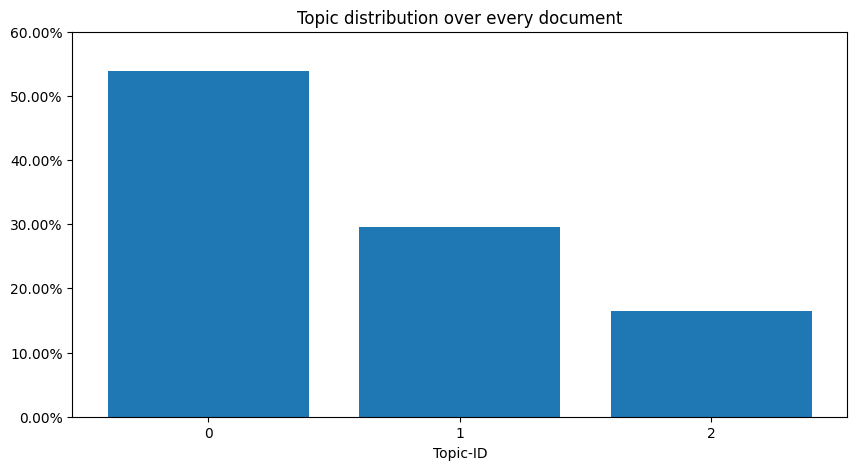

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(df_topic_dists.Topic_ID, df_topic_dists.percent)
ax.set_xlabel("Topic-ID")
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{y:.2f}%' for y in ax.get_yticks()])
_ = ax.set_title('Topic distribution over every document')

#### 4.3.2 Keywords for each Topic

In [ ]:
df_topic_keywords = pd.DataFrame(best_lda.components_)
df_topic_keywords.columns = countV_words
df_topic_keywords.index = colnms
df_topic_keywords.head()

,'m,'s,abl,absolut,accur,actual,adjust,alarm,almost,alreadi,...,wish,within,without,work,worn,worth,would,wrist,year,yet
Topic-0,27.490279,188.948389,12.323427,8.514829,11.512746,8.588594,8.883136,3.096949,19.001506,10.068421,...,9.642539,0.722058,22.436363,68.086782,12.387109,11.637695,64.797048,59.788015,33.974492,11.983259
Topic-1,3.117927,21.179735,0.385833,8.104948,0.552184,0.554890,3.082669,0.438433,0.377426,2.370764,...,1.455996,9.136147,1.431471,57.402675,0.445048,2.888083,2.747471,2.920326,18.822918,2.488512
Topic-2,15.831915,11.405807,3.408815,0.459182,0.472280,6.849550,11.854866,13.206724,0.430732,0.451124,...,0.666388,2.384152,4.593935,2.562947,0.451310,2.683437,11.513921,6.414229,0.881384,2.358975


In [ ]:
n_kwds = 15
topic_keywds = pd.DataFrame()
for i in range(df_topic_keywords.shape[0]):
    topicID = f'Topic-{i}'
    locs = df_topic_keywords.loc[topicID].argsort()[::-1][:n_kwds]
    topic_keywds[topicID] = countV_words.take(locs)
topic_keywds.head(n_kwds)

,Topic-0,Topic-1,Topic-2
0,watch,watch,nice
1,look,good,watch
2,br,love,like
3,'s,work,n't
4,great,price,expect
5,n't,product,time
6,time,excel,purchas
7,band,batteri,pretti
8,one,bought,face
9,wear,gift,get


#### 4.3.3 Apply LDA model to new text

In [ ]:
text = df['review_body'][N-1:N]

text_matrix = countV_model.transform(text)
text_topic_probs = best_lda.transform(text_matrix)
topicID = f'Topic-{text_topic_probs.argmax()}'
print(f'new text: "{text.tolist()[0]}"')
print(f'Prabability of different topics: {np.round(text_topic_probs, 4).tolist()}')
print(f'The top-{n_kwds} keywords of the dominant topic:\n {topic_keywds[topicID].tolist()}')

new text: "Really large on the arm but that's what I wanted - thx!"
Prabability of different topics: [[0.8783, 0.0601, 0.0616]]
The top-15 keywords of the dominant topic:
 ['watch', 'look', 'br', "'s", 'great', "n't", 'time', 'band', 'one', 'wear', 'love', 'like', 'work', 'get', 'color']
